In [1]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# Federated convex optimization: Experimenting with multiclass logistic regression on the MNIST dataset

This notebook runs an experiment with two federated convex optimization approaches, used to fit a multiclass logistic regression model on the MNIST dataset.

In [173]:
# Import the MNIST dataset
current_dir = os.getcwd()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path=current_dir+'/mnist.npz')

In [174]:
# Shuffle training data order
p = np.random.permutation(X_train.shape[0])
X_train = X_train[p]
Y_train = Y_train[p]

In [175]:
X_train.shape, Y_train.shape

((60000, 28, 28), (60000,))

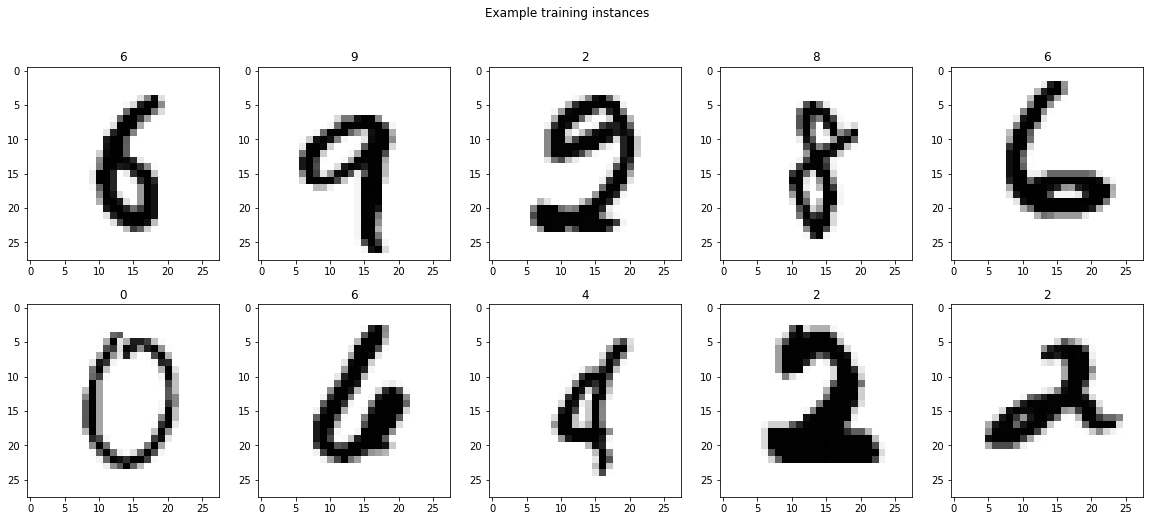

In [177]:
# Plot some generic examples

fig = plt.figure(figsize=(20,8))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(X_train[idx], cmap=mpl.cm.Greys)
    plt.title(Y_train[idx])
fig.suptitle('Example training instances')
plt.show()

In [183]:
def preprocess_data(X_train, Y_train):
    # Reshape the inputs as row vectors
    X = X_train.reshape(60_000, 28*28)
    
    # One-hot encode the labels
    y = to_categorical(Y_train)
    
    return X, y

In [184]:
X, y = preprocess_data(X_train, Y_train)

## Multiclass logistic regression implemementation

In [151]:
def softmax(scores):
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))+1e-6
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def log_likelihood(X, w, y):
    # Compute softmax predictions
    scores = np.dot(X, w)
    predictions = softmax(scores)
    
    # Log likelihood = 1/N * sum(log p(y_i | x_i))
    ll = np.sum(np.multiply(np.log(predictions), y)) / X.shape[0]
    return ll

def objective(X, w, y):
    log_loss = -log_likelihood(X, w, y)
    l2_norm = np.linalg.norm(w, 'fro')
    return log_loss, l2_norm

def gradient(X, w, y):
    # Compute softmax predictions
    scores = np.dot(X, w)
    predictions = softmax(scores)
    
    # Compute the gradient of the log loss
    grad = np.dot(np.transpose(X), predictions - y) / X.shape[0]
    
    # Compute the gradient of the l2 norm
    l2_grad = 2 * w
    
    return grad, l2_grad

def infer(X, w):
    scores = np.dot(X, w)
    return scores

def accuracy(X, w, y):
    y_hat = np.argmax(infer(X,w), axis=1)
    y = np.argmax(y, axis=1)
    acc = np.sum(np.equal(y, y_hat).astype(np.float32)) / y.shape[0]
    return acc

## Minibatch SGD

Here we perform a generic model fit using "federated" minibatch SGD, i.e. minibatch SGD that doesn't make repeated access to the same data.

In [198]:
def minibatch_sgd(X, y, lmbda=0, eta=0.00005):
    
    M = 10   # Number of machines in each round
    K = 5    # Number of stochastic gradients to calculate on each machine
    R = 100  # Number of rounds
    
    w0 = np.zeros((X.shape[1], y.shape[1]))
    
    w = w0
    next_idx = 0
    log_losses = []
    l2_norms = []
    
    for r in range(R):
        X_batch = X[next_idx:next_idx + K * M]
        y_batch = y[next_idx:next_idx + K * M]
        next_idx += K * M
        
        grad, l2_grad = gradient(X_batch, w, y_batch)
        w = w - eta * (grad + lmbda * l2_grad)
        
        log_loss, l2_norm = objective(X, w, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
        
    return log_losses, l2_norms, w

In [105]:
log_losses, l2_norms, w = minibatch_sgd(X, y, lmbda=0)

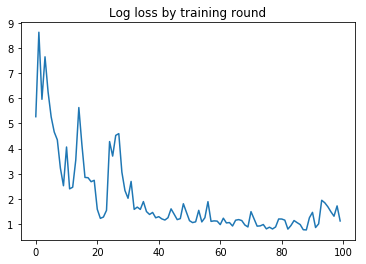

In [88]:
plt.plot(log_losses)
plt.title('Log loss by training round')
plt.show()

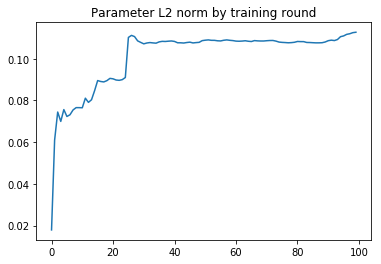

In [89]:
plt.plot(l2_norms)
plt.title('Parameter L2 norm by training round')
plt.show()

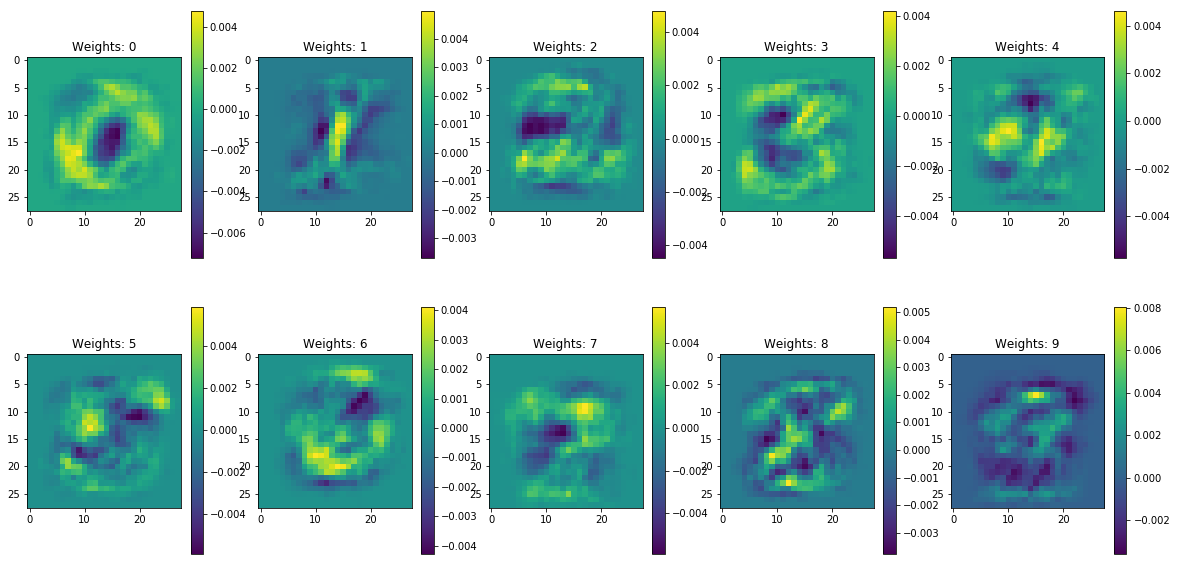

In [90]:
fig = plt.figure(figsize=(20,10))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(w[:,idx].reshape(28,28))
    plt.colorbar()
    plt.title(f'Weights: {idx}')

Everything looks OK -- getting parameters that look like we expect (you can see the shape of the numbers), and a satisfactory rate of convergence.

## Simulation of distributed nodes

In [187]:
class DataSource:
    """
    Acts like a "button" for random sample data. Reads in the entire sample dataset and stores it locally.
    Then returns data randomly to each machine to prevent re-use of the same data.
    """
    def __init__(self, X, Y):
        self._X = X
        self._Y = Y
        self._num_used = 0

    def generate_observations(self, count):
        X = self._X[self._num_used:self._num_used + count]
        Y = self._Y[self._num_used:self._num_used + count]
        self._num_used += count
        return (X, Y)

class Machine:
    """
    Represents an invididual machine in the network. We will instantiate it with some data,
    ask it to perform some gradient updates and return the results, then forget about this
    machine and the data that was given to it.
    """
    def __init__(self, source, data_count):
        X_local, Y_local = source.generate_observations(data_count)
        self._X = X_local # Locally stored predictor data
        self._Y = Y_local # Locally stored responder data
        self._m = data_count

    def execute_local_SGD(self, eta_inner, w_cur):
        w = np.copy(w_cur)
        grads = []
        for i in range(self._m):
            # Execute the local gradient step:
            grad, _ = gradient(self._X[ [i] ], w, self._Y[ [i] ])
            w = w - eta_inner * grad
            
            grads.append(grad)
        
        # Return the sum of observed gradients
        return np.sum(grads, axis=0)

    def execute_modified_DSVRG(self, w_cur, w_prev, g_prev, eta):
        # Iterate m steps of variance-reduced SGD on the local data
        w = np.copy(w_cur)
        for i in range(self._m):
            # Compute the gradient adjustment for the current iterate:
            # g_(t-1) - nabla f_(k,i)(w_(t-1))
            grad_adjustment = g_prev - gradient(self._X[ [i] ], w_prev, self._Y[ [i] ])[0]
            
            # Execute the variace reduced gradient step:
            w = w - eta * (gradient(self._X[ [i] ], w, self._Y[ [i] ])[0] + grad_adjustment)
            
            # TODO: possibly add gamma shrinkage term
        
        # Compute the local gradient at the iterate where we started the round
        g_local, _ = gradient(self._X, w_cur, self._Y)
        return w, g_local
        

## 1. Inner/outer step size method

In [192]:
def experiment_method_1(X, y, R=100, M=10, k=5, eta_inner=0.001, eta_outer=0.001):
    # Create a DataSource class to avoid repeated use of data
    source = DataSource(X, y)
    
    # Check that we have enough data for the desired experiment
    if R * M * k > X.shape[0]:
        print('Not enough training data')
        return
    
    # Initialize to zero
    w0 = np.zeros((X.shape[1], y.shape[1]))
    ws = [w0]
    
    log_losses = []
    l2_norms = []
    
    # Execute R outer iterations
    for _ in range(R):
        w_cur = ws[-1]
        
        # Generate M random machines to perform the Local SGD steps
        inner_results = [
            Machine(source, data_count=k).execute_local_SGD(eta_inner, w_cur)
        for _ in range(M)]
        
        # Perform the outer gradient step
        w_next = w_cur - eta_outer/M * np.sum(inner_results, axis=0)
        ws.append(w_next)
        
        # Record progress on the objective
        log_loss, l2_norm = objective(X, w_next, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
    
    return log_losses, l2_norms, ws[-1]

In [194]:
log_losses, l2_norms, w = experiment_method_1(X, y)

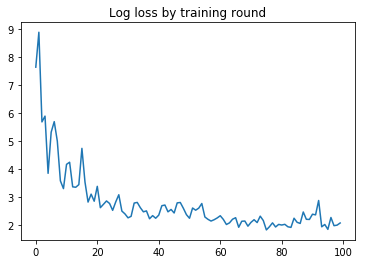

In [195]:
plt.plot(log_losses)
plt.title('Log loss by training round')
plt.show()

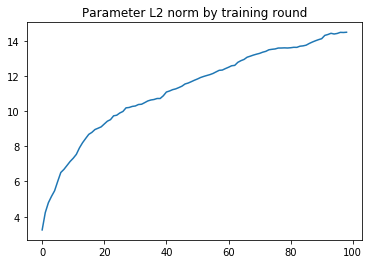

In [196]:
plt.plot(l2_norms[1:])
plt.title('Parameter L2 norm by training round')
plt.show()

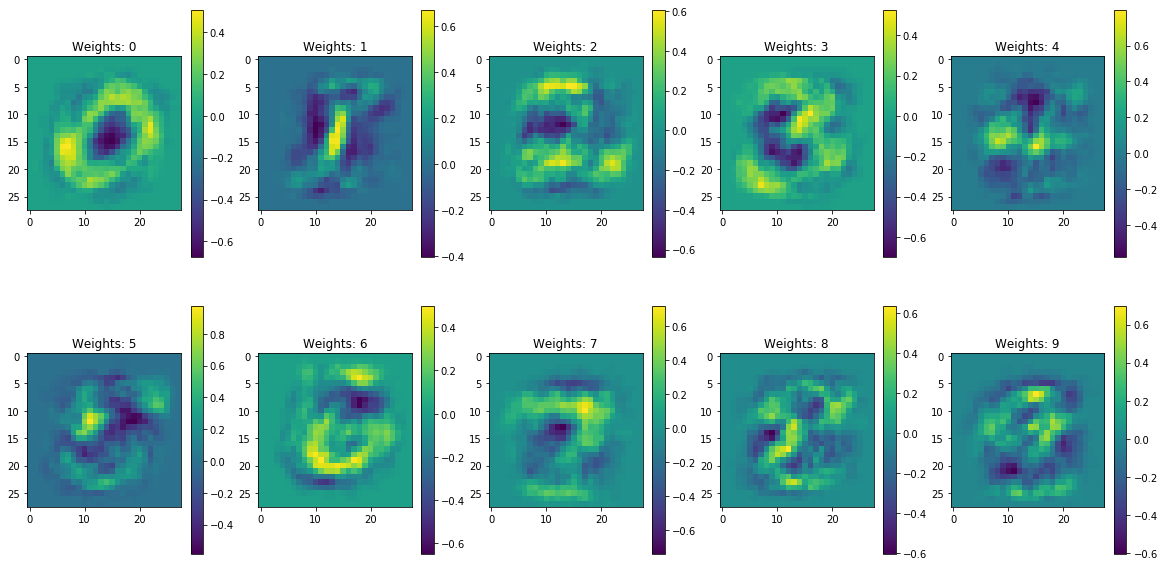

In [197]:
fig = plt.figure(figsize=(20,10))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(w[:,idx].reshape(28,28))
    plt.colorbar()
    plt.title(f'Weights: {idx}')

## 2. Modified DSVRG method

In [165]:
def experiment_method_2(X, y, T=1000, K=10, m=5, eta=0.001):
    # Create a DataSource class to avoid repeated use of data
    source = DataSource(X, y)
    
    # Check that we have enough data for the desired experiment
    if T * K * m > X.shape[0]:
        print('Not enough training data')
        return
    
    # Initialize to zero
    w0 = np.zeros((X.shape[1], y.shape[1]))
    g0 = np.zeros((X.shape[1], y.shape[1]))
    
    ws = [w0, w0]
    gs = [g0]
    
    log_losses = []
    l2_norms = []
    
    # Execute T outer iterations
    for _ in range(T):
        w_cur = ws[-1]
        w_prev = ws[-2]
        g_prev = gs[-1]
        
        # Generate K random machines to perform the modified DSVRG inner iteration updates
        inner_results = [
            Machine(source, data_count=m).execute_modified_DSVRG(w_cur, w_prev, g_prev, eta)
        for _ in range(K)]
        
        # Compute the next iterate, and the reference gradient
        w_next = np.mean([w for (w, _) in inner_results], axis=0)
        g_cur = np.mean([g for (_, g) in inner_results], axis=0)

        ws.append(w_next)
        gs.append(g_cur)
        
        # Record progress on the objective
        log_loss, l2_norm = objective(X, w_next, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
    
    return log_losses, l2_norms, ws[-1]

In [188]:
log_losses, l2_norms, w = experiment_method_2(X, y, eta=1e-5)

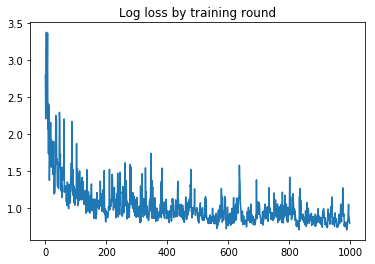

In [189]:
plt.plot(log_losses[1:])
plt.title('Log loss by training round')
plt.show()

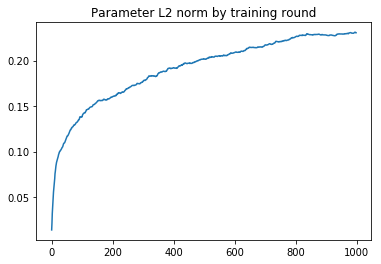

In [190]:
plt.plot(l2_norms[1:])
plt.title('Parameter L2 norm by training round')
plt.show()

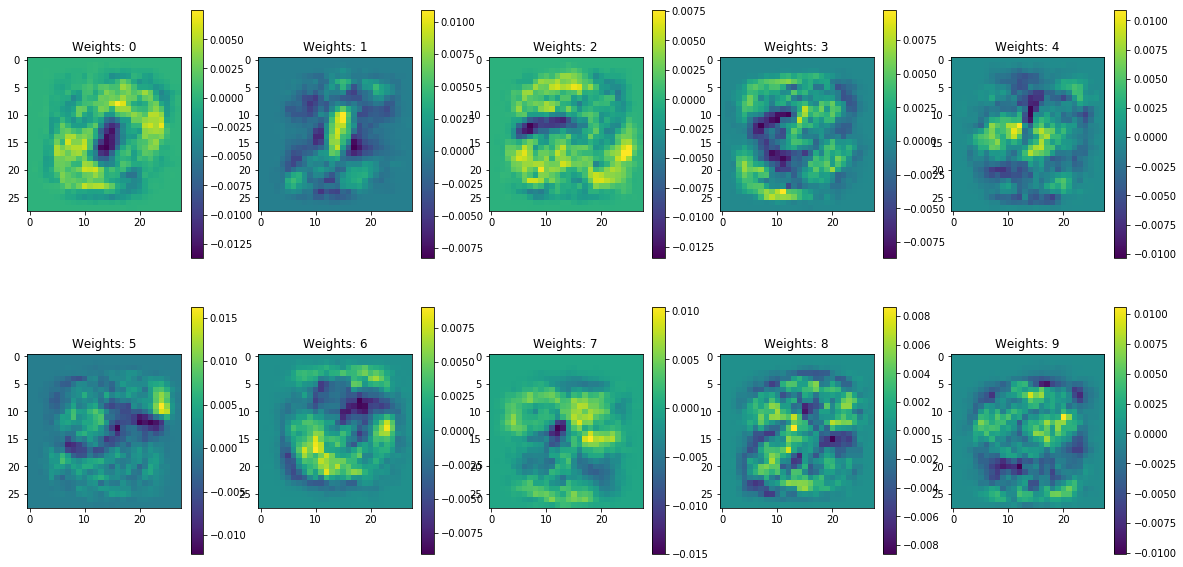

In [191]:
fig = plt.figure(figsize=(20,10))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(w[:,idx].reshape(28,28))
    plt.colorbar()
    plt.title(f'Weights: {idx}')